The original goal of this notebook was to predict the existing balancing behaviour of Citibike.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.metrics import categorical_accuracy

In [126]:
# Callback to plot model loss + accuracy during training
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('categorical_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

def read_csv(fname, base_path='../data/'):
    return pd.read_csv(f'{base_path}{fname}', index_col=0)
        
plot_losses = PlotLosses()

The rebalanced trips dataset will be used for base features.

In [127]:
trips = read_csv('rebalanced_bikes.csv.zip')
trips = trips.drop(['birth year', 'gender', 'tripduration', 'usertype'], axis=1)

trips['next starttime'] = pd.to_datetime(trips['next starttime'])
trips['stoptime'] = pd.to_datetime(trips['stoptime'])
trips['next start station id'] = pd.to_numeric(trips['next start station id'], downcast='unsigned')

In [128]:
trips['balancing delta'] = trips['next starttime'] - trips['stoptime']
trips['balancing delta'] = trips['balancing delta'].astype(np.int64) # Convert to nanoseconds

trips['stoptime hour'] = trips['stoptime'].apply(lambda x: x.hour)
trips['next starttime hour'] = trips['next starttime'].apply(lambda x: x.hour)

In [129]:
trips.head()

,bikeid,end station id,end station latitude,end station longitude,end station name,next start station id,next starttime,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,balancing delta,stoptime hour,next starttime hour
0,25542,3341,40.795346,-73.961860,central park west & w 102 st,3289,2017-01-11 21:36:50,3292,40.785785,-73.957481,5 ave & e 93 st,2017-01-11 15:43:04,2017-01-11 15:52:22,20668000000000,15,21
1,25542,324,40.689888,-73.981013,dekalb ave & hudson ave,532,2017-01-25 19:24:13,399,40.688515,-73.964763,lafayette ave & st james pl,2017-01-25 13:55:09,2017-01-25 14:01:37,19356000000000,14,19
2,25542,248,40.721854,-74.007718,laight st & hudson st,3064,2017-02-04 02:01:01,417,40.712912,-74.010202,barclay st & church st,2017-01-26 09:19:45,2017-01-26 09:24:29,750992000000000,9,2
3,25542,497,40.737050,-73.990093,e 17 st & broadway,2003,2017-02-08 13:14:33,527,40.744023,-73.976056,e 33 st & 2 ave,2017-02-08 12:00:59,2017-02-08 12:09:06,3927000000000,12,13
4,25542,447,40.763707,-73.985162,8 ave & w 52 st,517,2017-02-08 22:27:53,446,40.744876,-73.995299,w 24 st & 7 ave,2017-02-08 19:15:25,2017-02-08 19:27:02,10851000000000,19,22


In [130]:
avg_balancing_delta = trips.groupby('bikeid')['balancing delta'].agg('mean')
avg_balancing_delta = pd.to_timedelta(avg_balancing_delta)
avg_balancing_delta.head()

bikeid
14529   1 days 15:59:53.702127
14530   1 days 19:40:35.777777
14531   1 days 03:35:39.261904
14532   2 days 17:08:22.179487
14533   0 days 21:29:34.732142
Name: balancing delta, dtype: timedelta64[ns]

In [131]:
# Read in clusters
work_cluster = read_csv('work_cluster.csv')
work_cluster.head()

,dock_id,dock_name,_lat,_long,hour,avail_bikes_percent
1,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,1,0.580645
2,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,2,0.338710
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,3,0.322581
4,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,4,0.322581
5,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,5,0.322581


In [132]:
residential_cluster = read_csv('residential_cluster.csv')
residential_cluster.head()

,dock_id,dock_name,_lat,_long,hour,avail_bikes_percent
1,72,W 52 St & 11 Ave,40.767272,-73.993929,1,0.666667
2,72,W 52 St & 11 Ave,40.767272,-73.993929,2,0.666667
3,72,W 52 St & 11 Ave,40.767272,-73.993929,3,0.666667
4,72,W 52 St & 11 Ave,40.767272,-73.993929,4,0.666667
5,72,W 52 St & 11 Ave,40.767272,-73.993929,5,0.666667


In [133]:
low_cluster = read_csv('low_cluster.csv')
low_cluster.head()

,dock_id,dock_name,_lat,_long,hour,avail_bikes_percent
1,116,W 17 St & 8 Ave,40.741776,-74.001497,1,0.512821
2,116,W 17 St & 8 Ave,40.741776,-74.001497,2,0.461538
3,116,W 17 St & 8 Ave,40.741776,-74.001497,3,0.487179
4,116,W 17 St & 8 Ave,40.741776,-74.001497,4,0.410256
5,116,W 17 St & 8 Ave,40.741776,-74.001497,5,0.410256


To add additional features, the station clusters can be correlated with the balancing trips.

In [134]:
trips['start station cluster'] = 0
trips['end station cluster'] = 0
trips['next start station cluster'] = 0

trips.loc[trips['start station id'].isin(work_cluster['dock_id'].unique()), 'start station cluster'] = 1
trips.loc[trips['end station id'].isin(work_cluster['dock_id'].unique()), 'end station cluster'] = 1
trips.loc[trips['next start station id'].isin(work_cluster['dock_id'].unique()), 'next start station cluster'] = 1

trips.loc[trips['start station id'].isin(residential_cluster['dock_id'].unique()), 'start station cluster'] = 2
trips.loc[trips['end station id'].isin(residential_cluster['dock_id'].unique()), 'end station cluster'] = 2
trips.loc[trips['next start station id'].isin(residential_cluster['dock_id'].unique()), 'next start station cluster'] = 2

Next, the average bike availability for each particular station at the relevant hour can be obtained from the cluster data.

In [135]:
test = low_cluster.groupby(['dock_id', 'hour'])['avail_bikes_percent'].mean()
test[116, 6]

0.46520146520146516

In [136]:
def extract_avg_station_time(means, x):
    try:
        return means[x['end station id'], x['stoptime hour']+1]
    except KeyError:
        try:
            return means[x['end station id']].mean()
        except KeyError:
            return means.mean()


In [137]:
trips['avail_bikes_percent_low'] = np.float64(0)
trips['avail_bikes_percent_work'] = np.float64(0)
trips['avail_bikes_percent_res'] = np.float64(0)
trips['avail_bikes_percent'] = np.float64(0)

print("Populated initial values")
low_trips = trips.loc[trips['end station cluster'] == 0]
work_trips = trips.loc[trips['end station cluster'] == 1]
res_trips = trips.loc[trips['end station cluster'] == 2]

low_means = low_cluster.groupby('hour')['avail_bikes_percent'].mean()
work_means = work_cluster.groupby('hour')['avail_bikes_percent'].mean()
res_means = residential_cluster.groupby('hour')['avail_bikes_percent'].mean()

print("Populating averages")
trips['avail_bikes_percent_low'] = trips.apply(lambda x: low_means[x['stoptime hour']+1], axis=1)
print(" " * 4, "Low")
trips['avail_bikes_percent_work'] = trips.apply(lambda x: work_means[x['stoptime hour']+1], axis=1)
print(" " * 4, "Work")
trips['avail_bikes_percent_res'] = trips.apply(lambda x: res_means[x['stoptime hour']+1], axis=1)
print(" " * 4, "Res")
print("Populated averages")


trips.loc[trips['end station cluster'] == 0, 'avail_bikes_percent'] = low_trips.apply(lambda x: low_cluster[(low_cluster['dock_id'] == x['end station id']) & (low_cluster['hour'] == (x['stoptime hour'] + 1))]['avail_bikes_percent'].agg('mean'), axis=1)
print("Populated specifics for low")

trips.loc[trips['end station cluster'] == 1, 'avail_bikes_percent'] = work_trips.apply(lambda x: work_cluster[(work_cluster['dock_id'] == x['end station id']) & (work_cluster['hour'] == (x['stoptime hour'] + 1))]['avail_bikes_percent'].agg('mean'), axis=1)
print("Populated specifics for work")

trips.loc[trips['end station cluster'] == 2, 'avail_bikes_percent'] = res_trips.apply(lambda x: residential_cluster[(residential_cluster['dock_id'] == x['end station id']) & (residential_cluster['hour'] == (x['stoptime hour'] + 1))]['avail_bikes_percent'].agg('mean'), axis=1)
print("Populated specifics for res")

Populated initial values
Populating averages
     Low
     Work
     Res
Populated averages
Populated specifics for low
Populated specifics for work
Populated specifics for res


In [138]:
# trips = trips.drop(['avail_bikes_percent'], axis=1)
print(trips.shape)
trips.head()

(479801, 23)


,bikeid,end station id,end station latitude,end station longitude,end station name,next start station id,next starttime,start station id,start station latitude,start station longitude,...,balancing delta,stoptime hour,next starttime hour,start station cluster,end station cluster,next start station cluster,avail_bikes_percent_low,avail_bikes_percent_work,avail_bikes_percent_res,avail_bikes_percent
0,25542,3341,40.795346,-73.961860,central park west & w 102 st,3289,2017-01-11 21:36:50,3292,40.785785,-73.957481,...,20668000000000,15,21,0,2,2,0.389353,0.517542,0.453132,0.366667
1,25542,324,40.689888,-73.981013,dekalb ave & hudson ave,532,2017-01-25 19:24:13,399,40.688515,-73.964763,...,19356000000000,14,19,2,1,2,0.400225,0.517372,0.452368,0.603821
2,25542,248,40.721854,-74.007718,laight st & hudson st,3064,2017-02-04 02:01:01,417,40.712912,-74.010202,...,750992000000000,9,2,1,0,2,0.399794,0.510180,0.461280,NaN
3,25542,497,40.737050,-73.990093,e 17 st & broadway,2003,2017-02-08 13:14:33,527,40.744023,-73.976056,...,3927000000000,12,13,0,0,2,0.407323,0.513101,0.451203,NaN
4,25542,447,40.763707,-73.985162,8 ave & w 52 st,517,2017-02-08 22:27:53,446,40.744876,-73.995299,...,10851000000000,19,22,0,0,0,0.371603,0.488629,0.492876,0.300403


In [139]:
# trips[trips.isnull().any()] = 0.5
trips = trips.dropna()

In [140]:
trips['weekday'] = trips['stoptime'].apply(lambda x: x.weekday())
trips['is_weekday'] = trips['weekday'].apply(lambda x: x < 5)

trips.head()

,bikeid,end station id,end station latitude,end station longitude,end station name,next start station id,next starttime,start station id,start station latitude,start station longitude,...,next starttime hour,start station cluster,end station cluster,next start station cluster,avail_bikes_percent_low,avail_bikes_percent_work,avail_bikes_percent_res,avail_bikes_percent,weekday,is_weekday
0,25542,3341,40.795346,-73.961860,central park west & w 102 st,3289,2017-01-11 21:36:50,3292,40.785785,-73.957481,...,21,0,2,2,0.389353,0.517542,0.453132,0.366667,2,True
1,25542,324,40.689888,-73.981013,dekalb ave & hudson ave,532,2017-01-25 19:24:13,399,40.688515,-73.964763,...,19,2,1,2,0.400225,0.517372,0.452368,0.603821,2,True
4,25542,447,40.763707,-73.985162,8 ave & w 52 st,517,2017-02-08 22:27:53,446,40.744876,-73.995299,...,22,0,0,0,0.371603,0.488629,0.492876,0.300403,2,True
5,25542,3058,40.692371,-73.937054,lewis ave & kosciuszko st,530,2017-02-28 08:30:49,3064,40.696820,-73.937569,...,8,2,2,2,0.371688,0.483512,0.496193,0.461957,3,True
6,25542,412,40.715816,-73.994224,forsyth st & canal st,532,2017-03-21 09:46:27,241,40.689810,-73.974931,...,9,2,1,2,0.371688,0.483512,0.496193,0.482759,5,False


After correlating the clusters with the trips, we can see the balancing behaviour in terms of the clusters. 

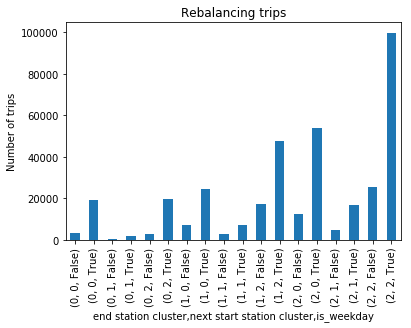

Percentage of bike rebalancing during the week 0.7909035957589322
Percentage of bike rebalancing to work cluster 0.29085186213806885
Percentage of bike rebalancing to residential cluster 0.5812326760440661
Percentage of bike rebalancing to residential cluster (from other clusters) 0.28748100831549883


In [141]:
rebalancing_clusters = trips.groupby(['end station cluster', 'next start station cluster', 'is_weekday'])['bikeid'].agg('count')

rebalancing_clusters.plot(kind='bar')
plt.ylabel("Number of trips")
plt.title("Rebalancing trips")
plt.show()

print("Percentage of bike rebalancing during the week", trips[trips['is_weekday'] == True]['bikeid'].agg('count') / trips.shape[0])
print("Percentage of bike rebalancing to work cluster", trips[trips['end station cluster'] == 1]['bikeid'].agg('count') / trips.shape[0])
print("Percentage of bike rebalancing to residential cluster", trips[trips['end station cluster'] == 2]['bikeid'].agg('count') / trips.shape[0])
print("Percentage of bike rebalancing to residential cluster (from other clusters)", trips[(trips['end station cluster'] == 2) & (trips['start station cluster'] != 2)]['bikeid'].agg('count') / trips.shape[0])

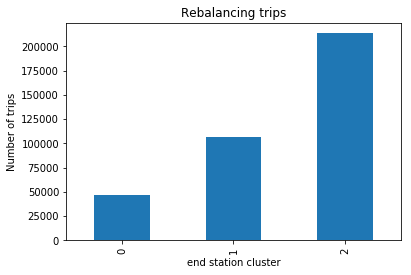

In [142]:
rebalancing_clusters = trips.groupby(['end station cluster'])['bikeid'].agg('count')

rebalancing_clusters.plot(kind='bar')
plt.ylabel("Number of trips")
plt.title("Rebalancing trips")
plt.show()

This next block will extract individual parts from the dates and build one hot vectors for these features. Then the data can be split into training and testing sets. The goal of a classifier is: given the ending month, day, hour, if the day is a workday, and the end station cluster, predict the cluster that the bike should be moved to.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

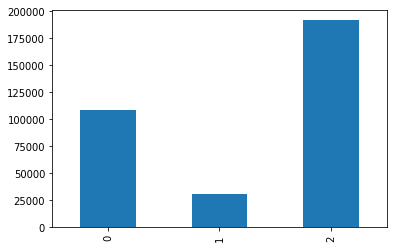

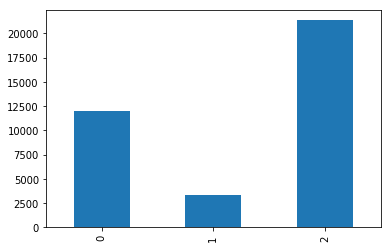

In [143]:
from sklearn.model_selection import train_test_split
# 'end station id', 
balancing_features = trips[['stoptime', 'stoptime hour', 'avail_bikes_percent', 'avail_bikes_percent_low', 'avail_bikes_percent_work', 'avail_bikes_percent_res', 'end station cluster']]
# end_station_cluster_feature = pd.get_dummies(trips['end station cluster'])
balancing_features['stopmonth'] = balancing_features['stoptime'].apply(lambda x: x.month)
balancing_features['stopday'] = balancing_features['stoptime'].apply(lambda x: x.day)
balancing_features['stophour'] = balancing_features['stoptime'].apply(lambda x: x.hour)
balancing_features['stop weekday'] = balancing_features['stoptime'].apply(lambda x: x.weekday() < 5)

balancing_features = balancing_features.drop(['stoptime', 'stoptime hour'], axis=1)
# balancing_features = pd.concat([balancing_features, end_station_cluster_feature], axis=1, join='inner')

categorial = ['stopmonth', 'stopday', 'stophour', 'end station cluster']

for c in categorial:
    balancing_features = pd.concat([balancing_features.drop([c], axis=1), pd.get_dummies(balancing_features[c], prefix=c)], axis=1)

balancing_labels = pd.get_dummies(trips['next start station cluster']) # Encode as a 1-hot vector
balancing_delta_label = trips['balancing delta']

X_train, X_test, Y_train, Y_test = train_test_split(balancing_features, balancing_labels, train_size=0.9)
features = X_train.shape[1]

Y_train.agg('sum').plot(kind='bar')
plt.show()

Y_test.agg('sum').plot(kind='bar')
plt.show()

In [144]:
X_train.head()

,avail_bikes_percent,avail_bikes_percent_low,avail_bikes_percent_work,avail_bikes_percent_res,stop weekday,stopmonth_1,stopmonth_2,stopmonth_3,stopmonth_4,stopmonth_5,...,stophour_17,stophour_18,stophour_19,stophour_20,stophour_21,stophour_22,stophour_23,end station cluster_0,end station cluster_1,end station cluster_2
449518,0.426667,0.371603,0.488629,0.492876,True,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
304750,0.489198,0.400225,0.517372,0.452368,True,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
440370,0.451049,0.384404,0.478100,0.490157,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
82537,0.499962,0.371688,0.483512,0.496193,True,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
272736,0.500000,0.370378,0.477908,0.502692,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


As the majority of the balancing trips had a target in the residential cluster (number 2), I will drop 50% of these to make the dataset more balanced. Otherwise, I found that the classifier would learn to always predict cluster 2. 

In [712]:
drop_rows = Y_train[Y_train[2] == 1].sample(frac=0.5).index
X_train = X_train.drop(drop_rows)
Y_train = Y_train.drop(drop_rows)

Y_train.agg('sum')

0    118794
1     71942
2    120542
dtype: int64

In [17]:
print(X_train[X_train.isnull().any(axis=1)].shape)
print(X_test[X_test.isnull().any(axis=1)].shape)

drop_train_rows = X_train[X_train.isnull().any(axis=1)].index
drop_test_rows = X_test[X_test.isnull().any(axis=1)].index

X_train = X_train.drop(drop_train_rows)
Y_train = Y_train.drop(drop_train_rows)
X_test = X_test.drop(drop_test_rows)
Y_test = Y_test.drop(drop_test_rows)

(104448, 72)
(11813, 72)


## Neural Network Model

This model will predict a probability distribution of balancing to each cluster. After experimenting with various iterations, I was able to gain a maximum test accuracy of ~$62\%$.

In [161]:
#     Dense(20, activation='tanh', kernel_regularizer=l2(0.01), activity_regularizer=l1(0.01)),
model = Sequential([
    Dense(300, input_shape=(features,), activation='sigmoid'),
    Dropout(0.15),
    Dense(100, activation='sigmoid'),
    Dropout(0.10),
    Dense(3),
    Activation('softmax')
])
#     Dense(806),


optimizer = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=[categorical_accuracy])

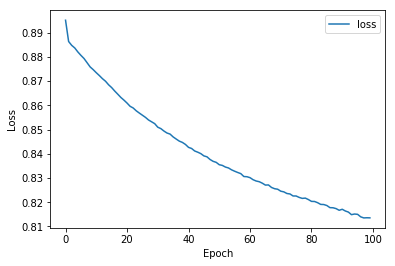

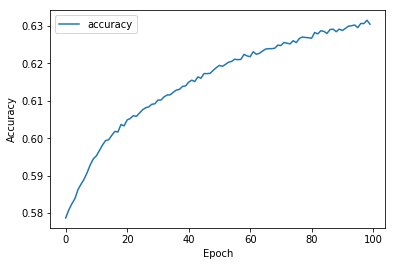

In [162]:
model.fit(x=X_train.values, y=Y_train.values, epochs=100, batch_size=500, shuffle=True, validation_split=0.2, callbacks=[plot_losses])

In [163]:
model.evaluate(X_test, Y_test)

36727/36727 [==============================] - 2s 41us/step


[0.8337671695479503, 0.6222125411968427]

In [148]:
for i in range(0, 20):
    d = X_test.values[i].reshape(1, features)
    prediction = model.predict(d)
    target = Y_test.iloc[i]
    print(d, '-> station:', prediction.argmax())
    print('target station: ', target.values.argmax())

[[0.4769680505521763 0.4073227094684509 0.5131014889589844
  0.45120305516014625 False 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 1]] -> station: 2
target station:  2
[[0.5 0.4025284046109517 0.5130300795967859 0.45419965681899493 True 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] -> station: 2
target station:  0
[[0.4952015496998195 0.3844042862932431 0.47809991990436757
  0.4901574440273738 False 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0]] -> station: 2
target station:  1
[[0.5 0.4073227094684509 0.5131014889589844 0.45120305516014625 False 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] -> s

## Decision Tree Model

I also created a decision tree classifier, this performed in a similar manner to the neural network model. I experimented by limiting the depth of the tree of prevent overfitting.

Current Depth:  25
Current Depth:  26
Current Depth:  27
Current Depth:  28
Current Depth:  29
Current Depth:  30
Current Depth:  31
Current Depth:  32
Current Depth:  33
Current Depth:  34
Current Depth:  35
Current Depth:  36
Current Depth:  37
Current Depth:  38
Current Depth:  39
Current Depth:  40
Current Depth:  41
Current Depth:  42
Current Depth:  43
Current Depth:  44
Current Depth:  45
Current Depth:  46
Current Depth:  47
Current Depth:  48
Current Depth:  49
[0.679021235013115, 0.6902634787422967, 0.6978631870974378, 0.7021349976855984, 0.7117828758482357, 0.718290428663486, 0.7310423278342344, 0.7372775981049134, 0.7433283213176055, 0.7495726676731036, 0.7572449847067971, 0.7615894039735099, 0.7658612145616704, 0.7692828985384478, 0.7737937126935097, 0.7776752516344516, 0.781605196361095, 0.7837532031016007, 0.7853354672217197, 0.788206535386142, 0.7898402306535689, 0.7912530745237325, 0.7922363170457949, 0.7940273311167517, 0.7949288888754429]
[0.5908187437035424, 0.59424

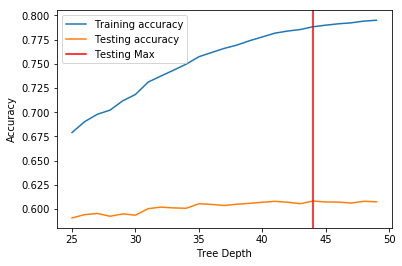

In [153]:
from sklearn import tree

min_depth, max_depth = 25, 50
train_acc = []
test_acc = []
for depth in range(min_depth, max_depth):
    print("Current Depth: ", depth)

    tree_model = tree.DecisionTreeClassifier(max_depth=depth, criterion='entropy')
    tree_model.fit(X_train, Y_train)
    train_acc.append(tree_model.score(X_train, Y_train))
    test_acc.append(tree_model.score(X_test, Y_test))

print(train_acc)
print(test_acc)
test_max = np.argmax(test_acc)

print("Best depth:", min_depth + test_max)

plt.plot(range(min_depth, max_depth), train_acc, label="Training accuracy")
plt.plot(range(min_depth, max_depth), test_acc, label="Testing accuracy")
plt.axvline(x=min_depth + test_max, label='Testing Max', color='r')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [154]:
for i in [0, 2, 10, 15, 25, 11]:
    d = X_test.values[i].reshape(1, features)
    prediction = tree_model.predict(d)
    target = Y_test.iloc[i]
    print(d, '->', prediction, '-> Cluster:', prediction.argmax())
    print(target.values, '-> Cluster: ', target.values.argmax())

[[0.4769680505521763 0.4073227094684509 0.5131014889589844
  0.45120305516014625 False 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 1]] -> [[0. 0. 1.]] -> Cluster: 2
[0 0 1] -> Cluster:  2
[[0.4952015496998195 0.3844042862932431 0.47809991990436757
  0.4901574440273738 False 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0]] -> [[0. 1. 0.]] -> Cluster: 1
[0 1 0] -> Cluster:  1
[[0.5092592592592593 0.3997941198846534 0.5101799924608992
  0.4612801699694579 True 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0]] -> [[1. 0. 0.]] -> Cluster: 0
[1 0 0] -> Cluster:  0
[[0.5160680529300568 0.3711393373237767 0.4804075030049398
  0.5001426230589271 True 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0

## Gradient Boosting Classifier

I also tried an ensemble tree classifier, using gradient boosting. This classifier was only able to gain a test accuracy of 60%.

In [155]:
from sklearn.ensemble import GradientBoostingClassifier

boost_model = GradientBoostingClassifier()
boost_model.fit(X_train.values, Y_train.apply(lambda y: y.argmax(), axis=1))
print("Test acc:", boost_model.score(X_test, Y_test.apply(lambda y: y.argmax(), axis=1)))

Test acc: 0.6057124186565742


In [156]:
for i in [0, 2, 10, 15, 25, 11]:
    d = X_test.values[i].reshape(1, features)
    prediction = boost_model.predict(d)
    target = Y_test.iloc[i]
    print(d, '->', prediction)
    print(target.values, '-> Cluster: ', target.values.argmax())

[[0.4769680505521763 0.4073227094684509 0.5131014889589844
  0.45120305516014625 False 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 1]] -> [2]
[0 0 1] -> Cluster:  2
[[0.4952015496998195 0.3844042862932431 0.47809991990436757
  0.4901574440273738 False 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0]] -> [2]
[0 1 0] -> Cluster:  1
[[0.5092592592592593 0.3997941198846534 0.5101799924608992
  0.4612801699694579 True 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0]] -> [2]
[1 0 0] -> Cluster:  0
[[0.5160680529300568 0.3711393373237767 0.4804075030049398
  0.5001426230589271 True 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 

## Logistic Classifier

Finally, I built a logistic classifier. This model could only gain approximately $58\%$ test accuracy.

In [157]:
from sklearn.linear_model import SGDClassifier

lin_model = SGDClassifier(loss='log', shuffle=True)
lin_model.fit(X_train.values, Y_train.apply(lambda y: y.argmax(), axis=1))


print("train acc", lin_model.score(X_train.values, Y_train.apply(lambda y: y.argmax(), axis=1)))
print("test acc", lin_model.score(X_test.values, Y_test.apply(lambda y: y.argmax(), axis=1)))

train acc 0.5805094103872765
test acc 0.5798731178696872


In [158]:
for i in [0, 2, 10, 15, 25, 11]:
    d = X_test.values[i].reshape(1, features)
    prediction = lin_model.predict(d)
    target = Y_test.iloc[i]
    print(d, '->', prediction)
    print(target.values.argmax())

[[0.4769680505521763 0.4073227094684509 0.5131014889589844
  0.45120305516014625 False 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 1]] -> [2]
2
[[0.4952015496998195 0.3844042862932431 0.47809991990436757
  0.4901574440273738 False 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0]] -> [2]
1
[[0.5092592592592593 0.3997941198846534 0.5101799924608992
  0.4612801699694579 True 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0]] -> [2]
0
[[0.5160680529300568 0.3711393373237767 0.4804075030049398
  0.5001426230589271 True 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 1]] -> [2]
0
[[0.542825361512792 0.39260570089806

In [159]:
X_train.to_csv('~/Downloads/x_train.csv')
Y_train.to_csv('~/Downloads/y_train.csv')
X_test.to_csv('~/Downloads/x_test.csv')
Y_test.to_csv('~/Downloads/y_test.csv')

# Y_train[Y_train[2] == 1].sample(frac=0.4).index

# X_train.head()

In [160]:
trips.shape

(367266, 25)

## Summary

After experiementing with various classifiers, I wasn't able to construct one with high accuracy. I believe that using more specific features, such as the availability of each station at the time the bike was docked. These more specific features would require more computational resources.